In this notebook, we're going to build a CNN that can help us to locate objects, rather than classify images. We will work with another cars data set which can be found [http://ai.stanford.edu/~jkrause/cars/car_dataset.html](here).

In [ ]:
%tensorflow_version 2.x

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.activations import relu
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_squared_error
import tensorflow.keras.applications.resnet50 as resnet50
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
from scipy.io import loadmat
from glob import iglob

Let's start by downloading and unpacking the data we'll need.

In [ ]:
!wget http://ai.stanford.edu/~jkrause/cars/car_devkit.tgz -O data.tgz

--2020-07-21 09:44:39--  http://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330960 (323K) [application/x-gzip]
Saving to: ‘data.tgz’

data.tgz            100%[===================>] 323.20K   550KB/s    in 0.6s    

2020-07-21 09:44:39 (550 KB/s) - ‘data.tgz’ saved [330960/330960]



In [ ]:
!wget http://imagenet.stanford.edu/internal/car196/cars_train.tgz

--2020-07-21 09:44:41--  http://imagenet.stanford.edu/internal/car196/cars_train.tgz
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 979269282 (934M) [application/x-gzip]
Saving to: ‘cars_train.tgz’

cars_train.tgz      100%[===================>] 933.90M  12.1MB/s    in 1m 45s  

2020-07-21 09:46:26 (8.89 MB/s) - ‘cars_train.tgz’ saved [979269282/979269282]



In [ ]:
!wget http://imagenet.stanford.edu/internal/car196/cars_test.tgz

--2020-07-21 09:46:27--  http://imagenet.stanford.edu/internal/car196/cars_test.tgz
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977350468 (932M) [application/x-gzip]
Saving to: ‘cars_test.tgz’

cars_test.tgz       100%[===================>] 932.07M  13.4MB/s    in 1m 54s  

2020-07-21 09:48:21 (8.20 MB/s) - ‘cars_test.tgz’ saved [977350468/977350468]



In [ ]:
!tar zxf data.tgz

In [ ]:
!tar zxf cars_train.tgz

In [ ]:
!tar zxf cars_test.tgz

Let's take a look at an example image:

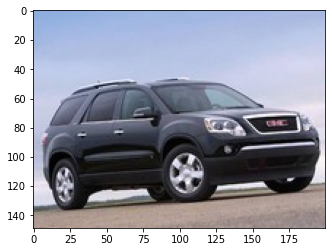

In [ ]:
example = image.load_img('cars_train/03189.jpg')
plt.imshow(example)
plt.show()

We're ready to get to coding. First, we'll define a helper function to fetch out the bounding box for an image.

This look quite daunting, but this is mostly due to the fact that the bounding box annotations are stored in `.mat` (MatLAB) files. Luckily, SciPy can read those out for us.

We'll also resize each image to a defined target size, as this is a tad easier to train than having to work with differently shaped images (as these are). We don't necessarily need to, but Keras prefers you give images of the same size in the same batch. As such, we need to account for this when reporting the bounding boxes as well. The function below hence returns the original bounding boxes, the file names, and the resized bounding boxes.

In [ ]:
target_size = (224, 224)

In [ ]:
def get_bb(dir, data, target_size=None):
  # ('bbox_x1', 'O'), ('bbox_y1', 'O'), ('bbox_x2', 'O'), ('bbox_y2', 'O')
  bb = []; bbr = []
  fn = []
  for r in data[0]:
    bb.append(np.array([r[i][0] for i in range(4)]))
    fn.append(r[5][0] if len(r) == 6 else r[4][0])
    img = image.load_img(dir + fn[-1])
    resize = img.size if target_size is None else (target_size[1], target_size[0])
    bbr.append(np.array([bb[-1][0] / img.size[0] * resize[0], bb[-1][1] / img.size[1] * resize[1], 
                         bb[-1][2] / img.size[0] * resize[0], bb[-1][3] / img.size[1] * resize[1]]))
  return np.array(bb), fn, np.array(bbr)

bb_train, fn_train, bbr_train = get_bb('cars_train/', loadmat('devkit/cars_train_annos.mat')['annotations'], target_size=target_size)
bb_test,  fn_test,  bbr_test  = get_bb('cars_test/',  loadmat('devkit/cars_test_annos.mat')['annotations'],  target_size=target_size)

We'll also make a quick helper function to show an image with its bounding box:

In [ ]:
def show_bb(img_path, bb, load_img_kwargs={}):
  example = image.load_img(img_path, **load_img_kwargs)
  fig, ax = plt.subplots(1)
  ax.imshow(example)
  rect = patches.Rectangle((bb[0],bb[1]), bb[2]-bb[0], bb[3]-bb[1], linewidth=3, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
  plt.show()

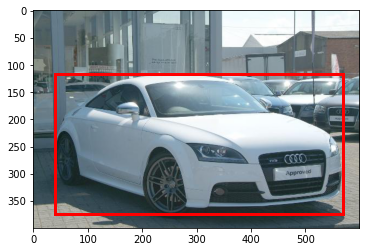

In [ ]:
show_bb('cars_train/{}'.format(fn_train[0]), bb_train[0])

And with a resized bounding box, it looks like this:

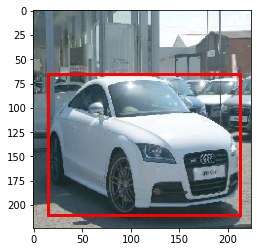

In [ ]:
show_bb('cars_train/{}'.format(fn_train[0]), bbr_train[0], load_img_kwargs={'target_size': target_size})

We still need to convert all the images themselves to arrays. Since we'll use Resnet50 here (we'll use transfer learning here as well to speed things up -- training an object localization CNN from scratch would take too long), we need to account for the correct preprocessing:

In [ ]:
def prepare_images(image_paths, preprocessor, load_img_kwargs={}):
  X = []
  for i, img_path in enumerate(image_paths):
    img = image.load_img(img_path, **load_img_kwargs)
    x = image.img_to_array(img)
    x = preprocessor(x)
    X.append(x)
  return np.array(X)

In [ ]:
X_train = prepare_images(['cars_train/' + p for p in fn_train], resnet50.preprocess_input, load_img_kwargs={'target_size': target_size})
X_test  = prepare_images(['cars_test/' + p for p in fn_test],   resnet50.preprocess_input, load_img_kwargs={'target_size': target_size})

Next, we load in the model, add some layers to replace its top, and freeze some layers, except for the last convolutional layers. Here, we decide to fine tune some more layers.

Note that our last layer now contains 4 output units: each pair will try to predict the x and y coordinates of the top left and bottom right corner of the bounding box respectively. Since we're dealing with a regression problem, we use MSE as our loss.

In [ ]:
model = resnet50.ResNet50(weights='imagenet', include_top=False)

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)

clipped_relu = lambda x: relu(x, max_value=224)
predictions = Dense(4, activation=clipped_relu)(x)

fullmodel = Model(inputs=model.input, outputs=predictions)

# Note: these are the layers in `model`, the new layers we've added above will remain trainable as well
for layer in model.layers:
  layer.trainable = layer.name.startswith('conv4') or layer.name.startswith('conv5')

fullmodel.compile(loss='mse', optimizer='adam')

Hint: try printing out `fullmodel.summary()` to see how large this network is compared to the ones we constructed earlier.

We're now ready to train. We're going to train for 10 epochs here. After every epoch, we'll also show the first instance from the test and train set to see how our model is doing.

Note: we do so here by just sticking `fit` inside of a for loop. Take a look at [Keras' callbacks](https://www.tensorflow.org/guide/keras/custom_callback) to see cleaner ways on how to do this, but we're keeping things simple.

128/128 [==============================] - 38s 295ms/step - loss: 1332.1760 - val_loss: 2792.0615


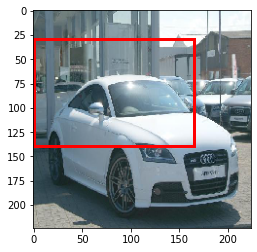

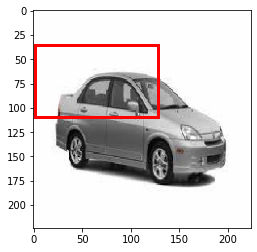

128/128 [==============================] - 36s 282ms/step - loss: 333.6837 - val_loss: 594.5878


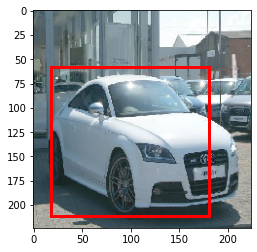

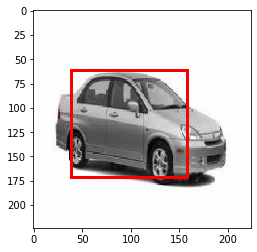

128/128 [==============================] - 36s 282ms/step - loss: 257.3943 - val_loss: 189.2116


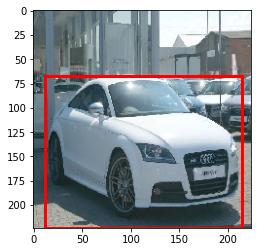

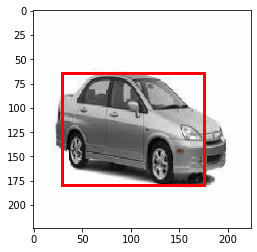

128/128 [==============================] - 36s 283ms/step - loss: 223.0847 - val_loss: 111.3652


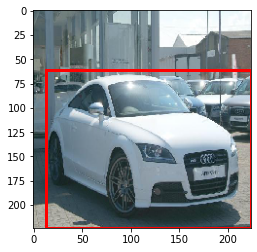

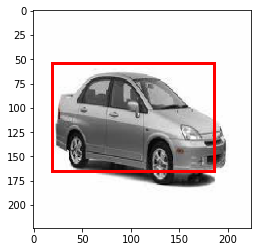

128/128 [==============================] - 36s 283ms/step - loss: 205.6129 - val_loss: 161.9492


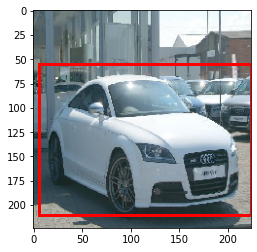

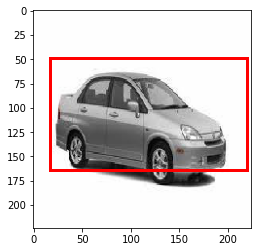

128/128 [==============================] - 36s 283ms/step - loss: 196.9784 - val_loss: 122.4656


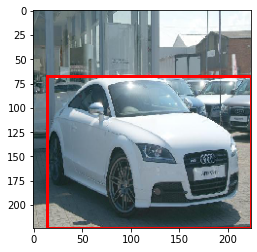

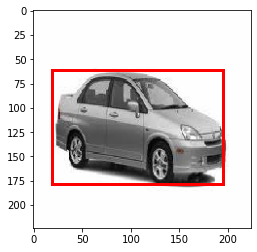

128/128 [==============================] - 36s 283ms/step - loss: 183.5367 - val_loss: 82.2406


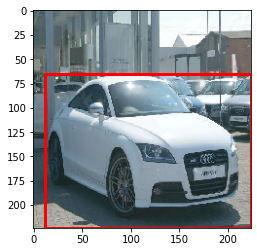

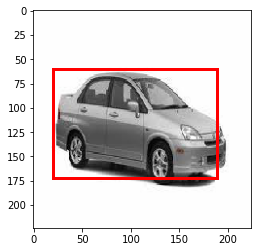

128/128 [==============================] - 36s 282ms/step - loss: 176.7898 - val_loss: 78.1932


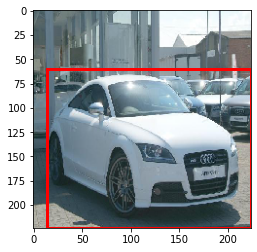

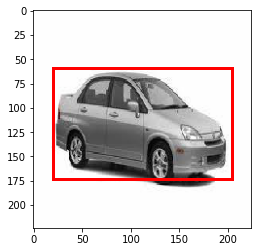

128/128 [==============================] - 36s 283ms/step - loss: 170.9407 - val_loss: 104.8262


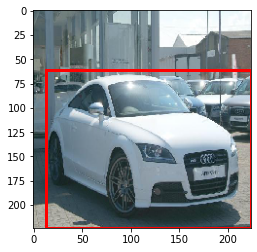

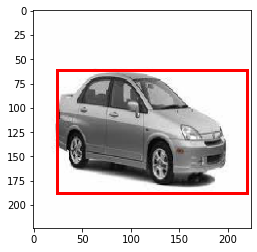

128/128 [==============================] - 36s 283ms/step - loss: 163.7527 - val_loss: 64.6330


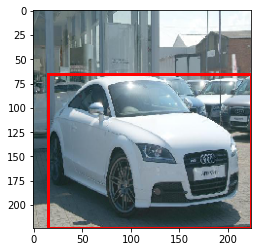

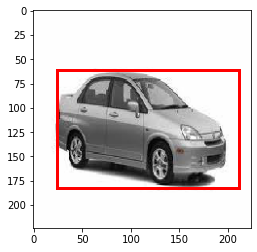

In [ ]:
batch_size = 64
epochs     = 10

for epoch in range(epochs):
  fullmodel.fit(X_train, bbr_train,
          batch_size=batch_size, epochs=1,
          validation_data=(X_test, bbr_test), verbose=1)
  
  bbtr_ = fullmodel.predict(np.expand_dims(X_train[0], axis=0))[0]
  bbte_ = fullmodel.predict(np.expand_dims(X_test[0], axis=0))[0]

  show_bb('cars_train/{}'.format(fn_train[0]), bbtr_, load_img_kwargs={'target_size': target_size})
  show_bb('cars_test/{}'.format(fn_test[0]),   bbte_, load_img_kwargs={'target_size': target_size})

And finally, let's try out our trained model on some other instances:

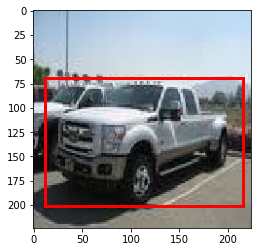

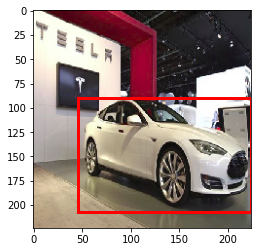

In [ ]:
bbtr_ = fullmodel.predict(np.expand_dims(X_train[4], axis=0))[0]
bbte_ = fullmodel.predict(np.expand_dims(X_test[4], axis=0))[0]

show_bb('cars_train/{}'.format(fn_train[4]), bbtr_, load_img_kwargs={'target_size': target_size})
show_bb('cars_test/{}'.format(fn_test[4]), bbte_, load_img_kwargs={'target_size': target_size})